In [1]:
#non-machine learning classification from dlc data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
#load data
csvpath = r"C:\Users\rylab\Downloads\red(1-852)DLC_resnet50_behavDec13shuffle1_200000.csv"
rawdat = pd.read_csv(csvpath)
dataframe = pd.read_csv(csvpath,skiprows=2,usecols=['x','y','x.1','y.1','x.3','y.3'])
dataframe = dataframe.values
#order: head,centre,foot

In [3]:
def frames_to_time(data, hz):
    max_t = len(data)/hz
    t_array = np.arange(0, max_t, 1/hz)
    return t_array

In [4]:
#preprocess data into 10 frame chunks array
time_duration = 10 #amount of frames looked back on to find behaviour (shuting paper)

data_chunks = []
for i in range(int(len(dataframe)/time_duration)):
    data_chunks.append(dataframe[(i*time_duration):((i+1)*time_duration),:])

data_chunks = np.asanyarray(data_chunks)

In [5]:
#create function to extract head-center distance, later do center-foot distance too
def findlength(data):
    def dist(data_line):
        distance_x = np.absolute(data_line[0] - data_line[2])
        distance_y = np.absolute(data_line[1] - data_line[3])
        tot_distance = np.sqrt((distance_x)**2 + (distance_y)**2)
        return tot_distance
    
    distances = []
    for i in range(len(data)):
        distances_chunk = []
        for j in range(len(data[0])):
            distance_head_cent = dist(data[i,j,0:4])
            distance_cent_foot = dist(data[i,j,2:6])
            #distance from head to center scaled by 5 as it is more accurate atm (and avg adjusted accordingly) - remove scaling when dlc works
            distance = (distance_head_cent*5 + distance_cent_foot)/6
            distances_chunk.append(distance)
        distances.append(distances_chunk)
    
    return distances       

In [6]:
distance_array = findlength(data_chunks)
distance_array = np.asanyarray(distance_array)
distance_array.shape

(85, 10)

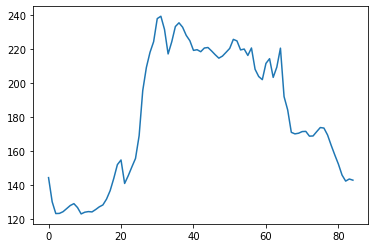

In [7]:
#find average distances over time chunk
distance_averages = []
for i in range(len(distance_array)):
        distance_averages.append(np.average(distance_array[i,:]))
plt.plot(distance_averages)

#this actually worked far better with only head and center...

In [17]:
len(distance_averages)

85

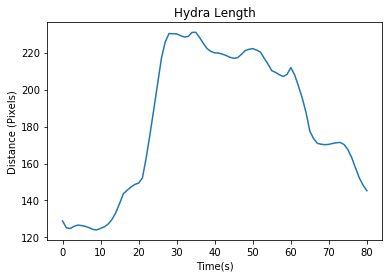

In [27]:
#smoothing step - helps remove outliers
N = 5
filtered_distance = np.convolve(distance_averages, np.ones((N,))/N, mode='valid')
xax = frames_to_time(filtered_distance, 10)*10

plt.plot(xax, filtered_distance)
plt.title('Hydra Length')
plt.ylabel('Distance (Pixels)')
plt.xlabel('Time(s)')
plt.savefig(r"C:\Users\rylab\Downloads\script_figures\length.png", format = 'png')

In [25]:
#function to extract angle at center (possibly use dot product)
def findangle(data):
    def dotprod_angle(data_line):
        foot_centre_vect = [np.absolute(data_line[2] - data_line[0]) , np.absolute(data_line[3] - data_line[1])]
        centre_head_vect = [np.absolute(data_line[4] - data_line[2]) , np.absolute(data_line[5] - data_line[3])]        
        dotprod = np.dot(foot_centre_vect,centre_head_vect)
        modulus_prod = np.linalg.norm(foot_centre_vect) * np.linalg.norm(centre_head_vect)       
        cos_angle = dotprod/modulus_prod
        angle = np.arccos(cos_angle) #dont need to worry about ambiguity since bending in either direction is the same
        return angle
    
    angles = []
    for i in range(len(data)):
        angle_chunk = []
        for j in range(len(data[0])):
            angle = dotprod_angle(data[i,j,:])
            angle_chunk.append(angle)
        angles.append(angle_chunk)  
        
    return angles

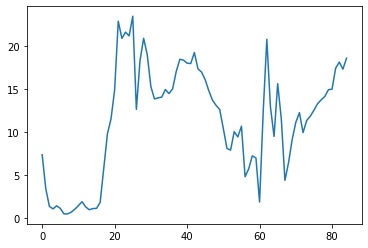

In [28]:
angle_array = findangle(data_chunks)
angle_array = np.degrees(angle_array)

angle_averages = []
for i in range(len(angle_array)):
    angle_averages.append(np.average(angle_array[i,:]))

plt.plot(angle_averages)

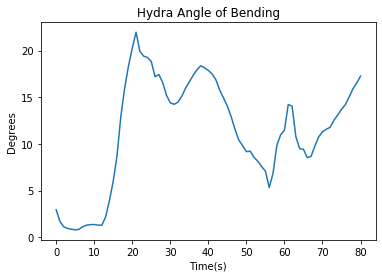

In [31]:
#smooth angles too
N = 5
filtered_angles = np.convolve(angle_averages, np.ones((N,))/N, mode='valid')
plt.plot(xax, filtered_angles)
plt.title('Hydra Angle of Bending')
plt.ylabel('Degrees')
plt.xlabel('Time(s)')
plt.savefig(r"C:\Users\rylab\Downloads\script_figures\angleplot.png", format = 'png')

In [12]:
#thresholding to find behaviour... should use a percentage of max length to account for varying hydra sizes
max_len = max(filtered_distance)
threshold = 0.85*max_len
max_len

231.04408348326726

In [13]:
#conditionals
behaviour = np.zeros(len(filtered_distance))
for i in range(len(filtered_distance)):
    if filtered_distance[i] < threshold:
        behaviour[i] = 1

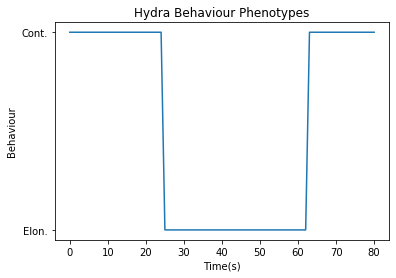

In [33]:
plt.plot(xax, behaviour)
plt.yticks([0,1],['Elon.','Cont.'])
plt.ylabel('Behaviour')
plt.xlabel('Time(s)')
plt.title('Hydra Behaviour Phenotypes')
plt.savefig(r"C:\Users\rylab\Downloads\script_figures\behaviour.png", format = 'png')
plt.show()

In [ ]:
#need to use derivative of the distance graph to better quantify elongation, contraction, contraction burst, and rythmic potential. Ignore angle for now and focus on the CB and RP networks!!